# **Create Synthetic Covid-19 X-Ray Images with CGAN**

### Jonathan Cauchi
### ID: 52197870 




In [ ]:
from PIL import Image, ImageOps
import os, os.path
import random
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.applications.resnet50 import ResNet50
import matplotlib.image as mpimg
%matplotlib inline

#unzip
!unzip /content/CS551G_DMV_Assessment_1_Dataset.zip

Archive:  /content/CS551G_DMV_Assessment_1_Dataset.zip
   creating: DMV_Assess_1_Covid-19_Dataset/
   creating: DMV_Assess_1_Covid-19_Dataset/Covid-19/
  inflating: DMV_Assess_1_Covid-19_Dataset/Covid-19/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: DMV_Assess_1_Covid-19_Dataset/Covid-19/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: DMV_Assess_1_Covid-19_Dataset/Covid-19/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: DMV_Assess_1_Covid-19_Dataset/Covid-19/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: DMV_Assess_1_Covid-19_Dataset/Covid-19/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: DMV_Assess_1_Covid-19_Dataset/Covid-19/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: DMV_Assess_1_Covid-19_Dataset/Covid-19/1-s2.0-S1684118220300682-main.pdf-003-b2.png  
  inflating: DMV_Assess_1_Covid-19_Dataset/Covid-19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1a.png  
  inflating: DMV_Assess_1_Covid-19_Dataset/Covid-

**Obtaining images and labels, and setting dimensions**

In [ ]:
#setting resolution to 446 x 446
IMG_WIDTH=446
IMG_HEIGHT=446
directory=r'/content/DMV_Assess_1_Covid-19_Dataset'

def obtain_imagelables(img_folder):
    data=[]
    labels=[]   
    for folder in os.listdir(directory):
        for image in os.listdir(os.path.join(directory, folder)):
            image_path= os.path.join(directory, folder,  image)
            image_data= cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)
            image_data=cv2.resize(image_data, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image_data=np.array(image_data)
            image_data = image_data.astype('float32')
            image_data /= 255 
            data.append(image_data)
            labels.append(image)
    return data

data = obtain_imagelables(directory)

#adding labels manually
final_data = []
for i in range(len(data)):
  if i <= 100:
    final_data.append([data[i],0]) # 0 for covid images
  else:
    final_data.append([data[i],1]) #1 for normal images

#random.shuffle(covid_data)
covid_data = final_data[0:100]
X = []
y = []

for i,j in covid_data:
   X.append(i)
   y.append(j)

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

# **Building the cGAN model from scratch**

In [ ]:
latent_dim = 100

# Get the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

# Get the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dropout(0.4)(x) #regularization, overfitting prevention
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = Dropout(0.4)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = Dropout(0.4)(x) 
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = Dropout(0.4)(x) 
  x = Dense(1, activation='sigmoid')(x) #binary outcome, therefore sigmoid activation function
  model = Model(i, x)
  return model

In [ ]:
# Reshaping data into a 1D Vector
N = 160 #80:20 train-test
H = IMG_HEIGHT
W = IMG_WIDTH
D = H * W 
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = x_train.reshape(-1, D) #flattening
x_test = x_test.reshape(-1, D)

# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0001, 0.5),  #choose parameters, either 0.0002 or 0.001
    metrics=['accuracy'])

# Compile
generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)
combined_model = Model(z, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5)) #either 0.0002 or 0.001

# Train the cGAN
batch_size = 32
epochs = 12000
sample_period = 100 

#auxiliary information
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
d_losses = []
g_losses = []

In [ ]:
 #rm -rf /content/artificial_images

**Run cell below to train the model. NOTE: It will take 60+ minutes to finish training process using GPU**

In [ ]:
from PIL import Image

def sample_images(epoch):
  rows, cols = 10, 5 # generating 10 x 5 = 50 images
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  imgs = 0.5 * imgs + 0.5

  #after every 200th epoch after and including 3000, save to a unique folder
  if epoch % 200 == 0 and epoch > 2999:  
    counter = 1
    if not os.path.exists('artificial_images'):
      os.makedirs('artificial_images')
    if not os.path.exists('artificial_images/artificial_images_epoch{}'.format(epoch)):
      os.makedirs('artificial_images/artificial_images_epoch{}'.format(epoch))
    for i in imgs:
      fig, axs = plt.subplots()
      print("Image generated at epoch %d" %epoch)
      axs.imshow(i.reshape(446, 446), cmap='gray')
      axs.axis('off')
      fig.savefig("artificial_images/artificial_images_epoch{}/{}.png".format(epoch,counter))
      counter += 1


for epoch in range(epochs):

  ### Train discriminator ###
  
  # Select a random batch of images
  idx = np.random.randint(10, 80, batch_size)
  x_train = np.array(x_train)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #Train generator
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  # Append the loss metrics
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  # if epoch % 100 == 0:
  #   print("Epoch: {}".format(epoch))

  sample_images(epoch)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Classification model - Transfer Learning - ResNet50**

In [71]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model.layers[-1].trainable = False #freeze final layer
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.4)) #overfit with 0.2
model.add(BatchNormalization())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))

opt = SGD(lr=0.001)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])



In [ ]:
tf.config.run_functions_eagerly(True)

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) 

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/DMV_Assess_1_Covid-19_Dataset',
    class_mode='categorical',
     batch_size = 25,
    subset='training') 

validation_generator = train_datagen.flow_from_directory(
    '/content/DMV_Assess_1_Covid-19_Dataset', 
    class_mode='categorical',
     batch_size = 25,
    subset='validation') 


history = model.fit(
    train_generator,
    validation_data = validation_generator, 
    epochs = 100,
    validation_steps=2)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/100
7/7 [==============================] - 10s 1s/step - loss: 0.1106 - accuracy: 0.9563 - val_loss: 0.1205 - val_accuracy: 0.9500
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 0.1299 - accuracy: 0.9625 - val_loss: 0.1744 - val_accuracy: 0.9500
Epoch 3/100
7/7 [==============================] - 8s 1s/step - loss: 0.0768 - accuracy: 0.9625 - val_loss: 0.1798 - val_accuracy: 0.9250
Epoch 4/100
7/7 [==============================] - 9s 1s/step - loss: 0.0896 - accuracy: 0.9875 - val_loss: 0.1051 - val_accuracy: 0.9500
Epoch 5/100
7/7 [==============================] - 9s 1s/step - loss: 0.0499 - accuracy: 0.9750 - val_loss: 0.1500 - val_accuracy: 0.9500
Epoch 6/100
7/7 [==============================] - 8s 1s/step - loss: 0.0447 - accuracy: 0.9812 - val_loss: 0.1387 - val_accuracy: 0.9500
Epoch 7/100
7/7 [==============================] - 8s 1s/step - loss: 0.0601 - accuracy: 0.9812 - val_loss: 0.1156 - val_accuracy: 0.9500
Epoch 8/100
7/7 [================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


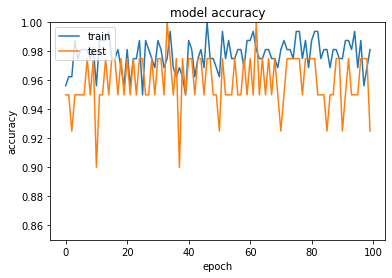

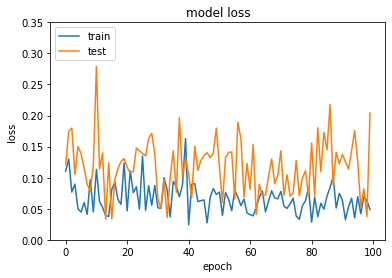

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0.85, 1.00])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0.00,0.35])
plt.show()

In [ ]:
scoreSeg = model.evaluate_generator(validation_generator, 40)
print(scoreSeg)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


[0.12838418781757355, 0.949999988079071]


# **Classification on Synthetic Images** 

In [21]:
covid_path = "/content/DMV_Assess_1_Covid-19_Dataset/Covid-19/"
normal_path = "/content/DMV_Assess_1_Covid-19_Dataset/Normal/"

imgs_covid = []
for i in os.listdir(covid_path):
  og_image = Image.open(covid_path+i)
  gray_image = ImageOps.grayscale(og_image)
  imgs_covid.append(gray_image)


imgs_normal = []
for i in os.listdir(normal_path):
  og_image = Image.open(normal_path+i)
  gray_image = ImageOps.grayscale(og_image)
  imgs_normal.append(gray_image)

In [22]:
imgs_gans = []
gans_path = '/content/drive/MyDrive/artificial_images_epoch4000/'
for i in os.listdir(gans_path):
  og_image = Image.open(gans_path+i)
  # gray_image = ImageOps.grayscale(og_image)
  imgs_gans.append(og_image)


images_gans = random.sample(imgs_gans,50)
images_covid = random.sample(imgs_covid,50)
final_images = images_gans + images_covid


In [23]:
len(final_images)

100

In [25]:
 #rm -rf /content/final_images

In [26]:
if not os.path.exists('final_images'):
  os.makedirs('final_images')

if not os.path.exists('final_images/Covid-19'):
  os.makedirs('final_images/Covid-19')

if not os.path.exists('final_images/Normal'):
  os.makedirs('final_images/Normal')

counter = 0
for img in final_images:
  counter+=1
  img.save("final_images/Covid-19/%d.png" %counter)

counter = 0
for img in imgs_normal:
  counter+=1
  img.save("final_images/Normal/%d.png" %counter)


In [73]:
tf.config.run_functions_eagerly(True)

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/final_images',
    class_mode='categorical',
     batch_size = 16,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    '/content/final_images', # same directory as training data
    class_mode='categorical',
     batch_size = 16,
    subset='validation') 

history = model.fit_generator(
    train_generator,
    validation_data = validation_generator, 
    epochs = 100,
    validation_steps=2)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/100
10/10 [==============================] - 9s 903ms/step - loss: 0.1303 - accuracy: 0.9438 - val_loss: 0.5462 - val_accuracy: 0.5312
Epoch 2/100
10/10 [==============================] - 9s 906ms/step - loss: 0.1656 - accuracy: 0.9375 - val_loss: 0.5063 - val_accuracy: 0.5625
Epoch 3/100
10/10 [==============================] - 9s 884ms/step - loss: 0.1282 - accuracy: 0.9438 - val_loss: 0.5582 - val_accuracy: 0.5938
Epoch 4/100
10/10 [==============================] - 9s 887ms/step - loss: 0.1080 - accuracy: 0.9500 - val_loss: 0.5079 - val_accuracy: 0.6875
Epoch 5/100
10/10 [==============================] - 9s 875ms/step - loss: 0.1221 - accuracy: 0.9563 - val_loss: 0.4861 - val_accuracy: 0.6562
Epoch 6/100
10/10 [==============================] - 9s 901ms/step - loss: 0.1402 - accuracy: 0.9563 - val_loss: 0.4395 - val_accuracy: 0.8750
Epoch 7/100
10/10 [==============================] - 9s 899ms/step - loss: 0.1571 - accuracy: 0.9500 - val_loss: 0.4637 - val_accuracy: 0.7500

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


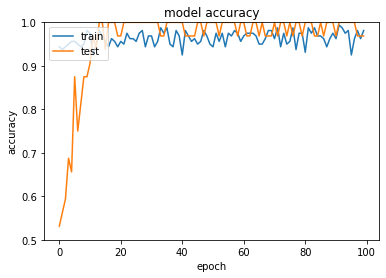

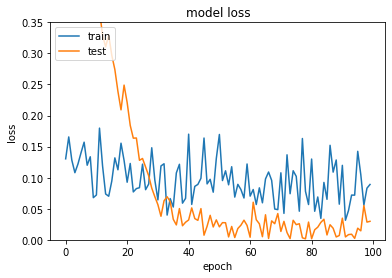

In [74]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0.50, 1.00])
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0.00,0.35])
plt.show()